Goal: Classify people into one 4 economic groups

# Game plan

1. Inspect and clean data (I used [this](https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough/notebook) to help me when I couldn't figure out what I wanted to implement, but I came up with what to clean and what I wanted to do before I actually looked for help in cleaning)

2. Modeling

3. Feature construction and the like

## Inspect and clean data

In [610]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [615]:
train_df = pd.read_csv("/Users/jacobbills/Desktop/python/costa rica/train.csv") # import the data set
test_df = pd.read_csv("/Users/jacobbills/Desktop/python/costa rica/test.csv") # import the test set

In [520]:
train_df.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [616]:
train_id = train_df.Id
train_df.drop(columns = 'Id', inplace =True) #Gets rid of the id column
target_train = train_df.Target #seperate data frame for our target

So as normal, I quickly inspected the data and then took out the Id column and separated out the target column. Next, I'll see how many people fall in each category. As can be seen, it is way unbalanced, with most people in category 4 (not at risk). This means my models will probably do the best fitting those people and accuracy is not a great measure (but I'll be looking at it anyway).

Text(0,0.5,'Number of People')

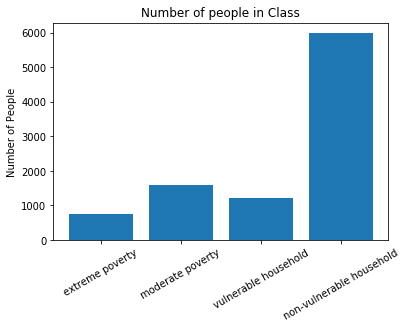

In [617]:
target_dict = dict(train_df['Target'].value_counts())
plt.bar(target_dict.keys(), target_dict.values())
plt.title("Number of people in Class")
plt.xticks([1,2,3,4], ['extreme poverty', 'moderate poverty', 'vulnerable household', 'non-vulnerable household'],
          rotation=30)
plt.ylabel("Number of People")

Next I take a look at the data and find out what is an object. There's 4. 

In [618]:
# I found the objects using .info(verbose=1) but I'm leaving that out for space purposes
strings = ['idhogar', 'dependency', 'edjefe', 'edjefa']
train_df[strings].head(10)

,idhogar,dependency,edjefe,edjefa
0,21eb7fcc1,no,10,no
1,0e5d7a658,8,12,no
2,2c7317ea8,8,no,11
3,2b58d945f,yes,11,no
4,2b58d945f,yes,11,no
5,2b58d945f,yes,11,no
6,2b58d945f,yes,11,no
7,d6dae86b7,yes,9,no
8,d6dae86b7,yes,9,no
9,d6dae86b7,yes,9,no


The best way to deal with this will be to turn the education and dependency variables into regular sorts of variables and then probably drop the household id. For the education variables, a no means that the head of household is notof that gender, so no is 0. The guide says that yes = 1, I don't know where this came from but seems reasonable enough. I tried messing around with some double-for loops but couldn't get them to work so I learned about mapping replacement instead.

In [619]:
string2 = strings[1:] # since the first variable is the household id
gmap = {'yes': 1, 'no': 0} # map of how to replace things

for i in string2: # simple for-loop to replace those three columns according to the map 
    train_df[i] = train_df[i].replace(gmap).astype(np.float64)

Next I'll check for nulls and impute missing values. I'll also drop the 'idhogar' column because it doesn't seem very useful right now. 

In [620]:
idhogar_train = train_df[strings[0]]
train_df.drop(columns = strings[0], inplace =True) #Gets rid of the idhogar column
is_null = train_df.columns[train_df.isnull().any()]
print(is_null)

Index(['v2a1', 'v18q1', 'rez_esc', 'meaneduc', 'SQBmeaned'], dtype='object')


'v18q1' is number of tablets in the household, so my guess is that all the nulls should be zeros and will fill in accordingly. The rest are a bit more confusing and will probably take some work to figure out how to do them best. 

'v2a1' is the monthly rent, so presumably if it is unavailable that means that the people own their own homes. We can check this with the various 'tipovivi#' variables. If I am correct, than NaN is highly correlated with 'tipovivi1/2' "own own home/paying off home". I am correct, most of the missing values (though not all) are because the people own their own homes, so I'll fill those ones in with a zero. 

'rez_esc' is years behind school. My guess is that this mostly is for people who would be expected to be in school so people outside of school would be empty. A description for the nulls and not nulls show that most of the nulls are well about 24, while all the not nulls are between 7 and 17. This means that I can fill anyone outside the school range with a zero and then see how many are left. Doing this leaves one 10 year old, who Im not sure how to deal with (probably give a 0 for ease).

'meaneduc' is the average number of years of education for adults. There's only 5 missing variables (this is also true for 'SQBmeaned') so I'll fill these in with the averages.

Doing all of this just leaves the missing numbers in 'tipovivi4/5'. Looking at the values counts shows that all households in this category have a missing number for rent. Seeing as this is "precarious" and "other" I'm guessing these are a lot of slum houses and the like, so probably not much rent. I'll check the target though. The graphs show that while this may be an okay assumption, it probably isn't a reasonable one especially for 'tipovivi5'. So I'm still not sure how to handle this. I think I'll go with the median values and hope for the best (along with a flag to say that it was imputed). 

In [621]:
train_df['v18q1'] = train_df['v18q1'].fillna(0)  # fill in v18q1 with 0

In [622]:
ownership = ['tipovivi1', 'tipovivi2', 'tipovivi3', 
             'tipovivi4', 'tipovivi5'] # list of the different ownership variables
rent = train_df['v2a1']
for i in ownership: # tells me the number of missing for each sort of housing variable
    print(train_df.loc[rent.isnull(),i].sum()) 

5911
0
0
163
786


In [528]:
train_df.loc[(train_df['tipovivi1'] == 1), 'v2a1'] = 0 #replace all those missing rents for people who own houses

In [529]:
print(train_df.loc[train_df['rez_esc'].isnull()]['age'].describe()) # years education behind looks like what 
print(train_df.loc[train_df['rez_esc'].notnull()]['age'].describe()) # and if it isn't missing, what's it like?
train_df.loc[(train_df['age'] > 17), 'rez_esc'] = 0
train_df.loc[(train_df['age'] < 7, 'rez_esc')] = 0
train_df['rez_esc'] = train_df['rez_esc'].fillna(0) 

count    7928.000000
mean       38.833249
std        20.989486
min         0.000000
25%        24.000000
50%        38.000000
75%        54.000000
max        97.000000
Name: age, dtype: float64
count    1629.000000
mean       12.258441
std         3.218325
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64


In [530]:
educ = ['meaneduc', 'SQBmeaned'] # the other two variables
for i in educ: #checking how many outliers
    print(train_df[i].isnull().value_counts())

for i in educ: #filling in with the mean
    train_df[i] = train_df[i].fillna(train_df[i].mean())
    
for i in educ: #checking to see if it worked
    print(train_df[i].isnull().value_counts())

False    9552
True        5
Name: meaneduc, dtype: int64
False    9552
True        5
Name: SQBmeaned, dtype: int64
False    9557
Name: meaneduc, dtype: int64
False    9557
Name: SQBmeaned, dtype: int64


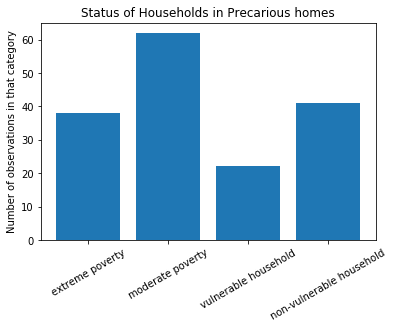

In [531]:
remainers = ownership[3:] # see ownership list from earlier

dict1 = dict(train_df.loc[train_df[remainers[0]] == 1, 'Target'].value_counts()) # since I have pre-written fuctions for dictionaries
dict2 = dict(train_df.loc[train_df[remainers[1]] == 1, 'Target'].value_counts())
    
def statusplot(dictionary, title): #defines a way of plotting values from a dictionary
    plt.bar(dictionary.keys(), dictionary.values()) #plots the values
    plt.xticks([1,2,3,4], ['extreme poverty', 'moderate poverty', 'vulnerable household', 'non-vulnerable household'],
          rotation=30) #sets up a clean x axis
    plt.ylabel('Number of observations in that category') # y axis
    plt.title('Status of Households ' + title) #one sort of title for this 
    
statusplot(dict1, 'in Precarious homes')

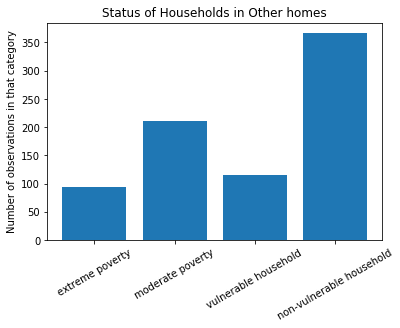

In [532]:
statusplot(dict2, 'in Other homes') #in retrospect, I could have done this as a for-loop. Oh well.

In [533]:
train_df['v2a1-impute'] = train_df['v2a1'].isnull() # show that I imputed values
train_df['v2a1'] = train_df['v2a1'].fillna(train_df['v2a1'].median()) #median for ease
train_df.columns[train_df.isnull().any()]

Index([], dtype='object')

There's bunch of square terms. My guess is that these are highly correlated with the original terms and that in general I'd rather not start with polynomial terms in initial models. So I'll check the correlations and then probably drop all of them. After checking the correlations my thoughts about the correlations were confirmed (basically all over .94) so I will drop them.

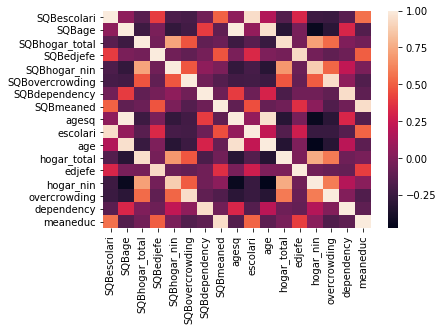

In [534]:
SQB = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency'
      , 'SQBmeaned', 'agesq'] # all the square terms
non_SQB = ['escolari', 'age', 'hogar_total', 'edjefe', 'hogar_nin', 'overcrowding', 'dependency', 'meaneduc']
both_SQB = SQB + non_SQB
SQB_corr = train_df[both_SQB].corr()

sns.heatmap(SQB_corr)

In [535]:
def corr_extract(var, sensitivity): # definine a function that will tell me where there is high correlation
    y = dict() #the plan is to get a dictionary that gives me the name and value
    count = 0 # set up the counter
    for e in var:
        if abs(e)<sensitivity: #most common is lower correlation so I'll get rid of those first
            count = count + 1 #move to the next one
        elif abs(e)==1: # get rid of perfect correlation because that isn't very interesting
            count = count + 1 #
        else: 
            x = var.index[count] #extract the name from the series
            y[x] = e #key: index, value: correlation
            count = count + 1 # move to the next one
    return y 

def i_corr_extract(list_corr, var, sensitivity): #for doing a correlation extract except iterated
    for x in list_corr:
        print(x)
        print(corr_extract(var[x], sensitivity))
        print()

In [536]:
i_corr_extract(both_SQB, SQB_corr, .5) # I could rewrite this so that var is taken from the list, maybe.

SQBescolari
{'SQBmeaned': 0.510806349744939, 'escolari': 0.9433250715255214, 'meaneduc': 0.5605935539382516}

SQBage
{'age': 0.9580898540659534}

SQBhogar_total
{'SQBhogar_nin': 0.7339556080149506, 'hogar_total': 0.9501727040705933, 'hogar_nin': 0.712828734501634, 'overcrowding': 0.5423647281184741}

SQBedjefe
{'edjefe': 0.9337188866967435, 'meaneduc': 0.500060772528984}

SQBhogar_nin
{'SQBhogar_total': 0.7339556080149506, 'hogar_total': 0.684301855036975, 'hogar_nin': 0.884141453289388, 'overcrowding': 0.5227749496154747}

SQBovercrowding
{'overcrowding': 0.9450937275042812}

SQBdependency
{'dependency': 0.9442208598711309}

SQBmeaned
{'SQBescolari': 0.510806349744939, 'meaneduc': 0.9480025570948891}

agesq
{'age': 0.9580898540659534}

escolari
{'SQBescolari': 0.9433250715255214, 'meaneduc': 0.520049509478467}

age
{'SQBage': 0.9580898540659534, 'agesq': 0.9580898540659534}

hogar_total
{'SQBhogar_total': 0.9501727040705933, 'SQBhogar_nin': 0.684301855036975, 'hogar_nin': 0.7532460870

In [537]:
train_df = train_df.drop(columns = SQB) #dropping the squares

## Modeling

Now that I have some cleaner data, let's do some basic modelling to see how things could work. I imported a whole bunch of different classification models but for various reasons only ended up using a fraction of them. I couldn't get naive bayes or AdaBoost to work and never bothered doing a logistic regression. I also imported basically all the metrics that got mentioned at some point in the lectures, but mostly just used the accuracy score, f1 score, and classification report since those are easy to understand and use. As for how I will evaluate models, I'm cross-validating them using micro-f1 since macro-f1 was giving me problems. I will then consider how long it takes to run a model, if it seems to be over fitting the training data, and how well it does on test accuracy (though that's less important) and on the different f1, especially weighted f1 test.

In [273]:
## Models
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier # Logistic Regression and something I saw on the API
from sklearn.neighbors import KNeighborsClassifier #Nearest Neighbors
from sklearn.naive_bayes import MultinomialNB, ComplementNB, GaussianNB # different Bayesian models
from sklearn.svm import SVC #support vector machine
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier #ensemble models


## Useful tools
from sklearn.model_selection import train_test_split #to make splits
from sklearn.model_selection import GridSearchCV #to do cross validation
from sklearn.preprocessing import StandardScaler #scaler


# Metrics
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error #different ways of scoring
from sklearn.metrics import classification_report # classification report
from sklearn.metrics import confusion_matrix # confusion matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc


In [288]:
# make all the models easily callable
lgc = LogisticRegression()
knn = KNeighborsClassifier()
mnb = MultinomialNB()
svc = SVC()
tree = DecisionTreeClassifier()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier(random_state=0)
abc = AdaBoostClassifier

In [609]:
scaler = StandardScaler()
no_target = train_df.drop(columns = 'Target')
scaler.fit(no_target)
scaled_df = scaler.transform(no_target)

In [539]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df, target_train, test_size=.2, random_state = 11)
#set up the train test split

First model I used that worked was nearest neighbors. It took a really long time to run and probably is suffering from the curse of dimensionality right now. At first, I accidentally allowed for 1 and 3 neighbors, leading it to perform extremely well. However, it was way overfitting and I just didn't feel that good about it. That being said, it still seems to be over-fitting now but whatever. It actually performs very well but I won't use as my primary model because of that overfitting issue. It definitely does better (in most cases) with precision over recall and while it is exceptionally good at classifying things into the 4th category, it does worse with the smaller categories. 

In [315]:
# Nearest Neighbors
gridsearch = GridSearchCV(knn, {"n_neighbors": [5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='f1_micro', cv=3)
gridsearch.fit(X_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_train)
print("Train F1: {}".format(f1_score(y_train, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))

Best Params: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Train F1: [1. 1. 1. 1.]
Test Classification Report:
              precision    recall  f1-score   support

           1       0.86      0.74      0.80       141
           2       0.89      0.75      0.81       314
           3       0.88      0.68      0.77       242
           4       0.88      0.98      0.93      1215

   micro avg       0.88      0.88      0.88      1912
   macro avg       0.88      0.79      0.83      1912
weighted avg       0.88      0.88      0.88      1912

Train Accuracy: 1.0	Test accuracy: 0.8828451882845189


Next I tried a basic decision tree, not expecting it to be very good. Unsurprisingly, it liked to go deep and performed much worse than the nearest neighbors model (but wasn't overfitting as bad!). It also did better on precision than recall. I pulled out the features from my best model just to makes sure that worked, it did. 

In [285]:
# tree
gridsearch = GridSearchCV(tree, {"max_depth": [1, 3, 5, 7, 9, 11], "min_samples_leaf": [3 , 5 , 7 , 9]}, 
                          scoring='f1_micro', cv=3)
gridsearch.fit(X_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_train)
print("Train F1: {}".format(f1_score(y_train, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))

Best Params: {'max_depth': 11, 'min_samples_leaf': 3}
Train F1: [0.70095238 0.72423863 0.65437788 0.90570891]
Test Classification Report:
              precision    recall  f1-score   support

           1       0.69      0.50      0.58       141
           2       0.67      0.55      0.61       314
           3       0.61      0.49      0.54       242
           4       0.82      0.92      0.86      1215

   micro avg       0.77      0.77      0.77      1912
   macro avg       0.70      0.62      0.65      1912
weighted avg       0.76      0.77      0.76      1912

Train Accuracy: 0.8346631785480706	Test accuracy: 0.7714435146443515


In [308]:
#best tree
treeb = DecisionTreeClassifier(max_depth = 11, min_samples_leaf = 3)
treeb.fit(X_train, y_train)
feature_imptre = sorted(list(zip(train_df, treeb.feature_importances_)), key=lambda x: x[1], reverse=True)
feature_imptre

[('age', 0.14116739529764427),
 ('techoentrepiso', 0.07465791631662343),
 ('lugar6', 0.0642197855692105),
 ('area2', 0.05259072738412137),
 ('tipovivi2', 0.03891102031149154),
 ('r4m2', 0.028811910021457176),
 ('refrig', 0.02808424315666359),
 ('hacdor', 0.02262433433677883),
 ('etecho3', 0.022466888012337097),
 ('v18q', 0.021233823347074673),
 ('parentesco10', 0.019021647627468177),
 ('r4h1', 0.018082855446533833),
 ('noelec', 0.0179962366055168),
 ('coopele', 0.01765037739404932),
 ('area1', 0.01699100707613381),
 ('r4h3', 0.016327205704140566),
 ('r4m1', 0.015433215772270593),
 ('r4m3', 0.015081126496255658),
 ('sanitario5', 0.014687504087212958),
 ('escolari', 0.013900573559726983),
 ('v18q1', 0.013708373019126141),
 ('instlevel4', 0.01361801473478455),
 ('lugar5', 0.013028822698984642),
 ('paredzinc', 0.013017530915252408),
 ('instlevel3', 0.011767750487662366),
 ('r4t3', 0.011563013693330184),
 ('sanitario6', 0.011458884657563567),
 ('abastaguadentro', 0.01085982187657586),
 ('ep

I like SVMs so I tried one. It took a really long time to run and actually came up with a polynomial model, which surprised me. Did worse than the nearest neighbors and I forgot to run the train accuracy to see how it did with over fitting. The train F1 seems to indicate it is somewhat overfitting but not as bad as some of the other models. Like all the models, it's best at classifying into 4. What is interesting is that the precision and recall for class 4 are actually the same, while most models so far did much better on recall than precision (for class 4). 

In [312]:
# SVM
gridsearch = GridSearchCV(svc, {"C": [0.2, 0.5, 0.7], "kernel": ['linear', 'poly', 'rbf'], 
                                'degree': [1, 2, 3], 'gamma': [1, 5, 11]}, scoring="f1_micro", cv=3)
gridsearch.fit(X_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))
print("Test Accuracy: {}".format(accuracy_score(y_test, gridsearch.predict(X_test))))

Best Params: {'C': 0.2, 'degree': 3, 'gamma': 1, 'kernel': 'poly'}
Test Accuracy: 0.8415271966527197


In [314]:
print("Train F1: {}".format(f1_score(y_train, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_test)
print(classification_report(y_test, y_pred_test))

Train F1: [0.88105727 0.840301   0.76799007 0.93153384]
Test Classification Report:
              precision    recall  f1-score   support

           1       0.71      0.75      0.73       141
           2       0.77      0.76      0.76       314
           3       0.69      0.64      0.66       242
           4       0.91      0.91      0.91      1215

   micro avg       0.84      0.84      0.84      1912
   macro avg       0.77      0.77      0.77      1912
weighted avg       0.84      0.84      0.84      1912



Moving into more serious models, I ran a random forest. It's still way overfitting (look at the F1 for train vs test) but is doing okay overall and shows good room for improvement. Interestingly, this one does much better on recall than the other models (except with class 4, so the reverse) and has some of the best F1 scores because of that, even if the weighted average f1 is a little lower than say nearest neighbors. Those good f1s make me like this model the most so far. I also created a features_importance list to use later

In [287]:
# RandomForestClassifier
gridsearch = GridSearchCV(rfc, {"n_estimators": [20, 50, 100, 200, 500], "max_depth": [1, 3, 5, 7, 9, 11], 
                                 "min_samples_leaf": [3 , 5 , 7 , 9], "max_features": [None, 'sqrt', 'log2']
                                , "class_weight": ["balanced", "balanced_subsample"], 'random_state': 9}, 
                          scoring='f1_micro', cv=3)
gridsearch.fit(X_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_train)
print("Train F1: {}".format(f1_score(y_train, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))

Best Params: {'class_weight': 'balanced_subsample', 'max_depth': 11, 'max_features': None, 'min_samples_leaf': 3, 'n_estimators': 500}
Train F1: [0.89581749 0.91353238 0.85043718 0.94546243]
Test Classification Report:
              precision    recall  f1-score   support

           1       0.64      0.87      0.73       141
           2       0.81      0.79      0.80       314
           3       0.62      0.81      0.70       242
           4       0.93      0.85      0.89      1215

   micro avg       0.83      0.83      0.83      1912
   macro avg       0.75      0.83      0.78      1912
weighted avg       0.85      0.83      0.84      1912

Train Accuracy: 0.9223021582733812	Test accuracy: 0.8331589958158996


In [540]:
##best parameters
rfcb = RandomForestClassifier(n_estimators=500, max_depth=11, min_samples_leaf = 3, max_features= None, 
                              class_weight = "balanced_subsample", random_state=9)
rfcb.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=11, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=None, oob_score=False, random_state=9,
            verbose=0, warm_start=False)

In [541]:
feature_imp_rfc = sorted(list(zip(train_df, rfcb.feature_importances_)), key=lambda x: x[1], reverse=True)

Next I did a Gradient Boosting Classifier which took all night to run. It is definitely overfitting the data (though not much worse than some of the other ones). I decided to see where the early stopping would put me, which was at 602. This makes the model much more runnable, but also not any better (actually quite a bit worse because of more over fitting) than the random forest, so I'll just stick with that. I also tried a faster running gridsearch using the early stopping. Didn't really fix the over fitting and it perfomed worse, so random forest it is!

In [289]:
# GradientBoostingClassifier
gridsearch = GridSearchCV(gbc, {"n_estimators": [100, 2000, 5000], "max_depth": [1, 2, 3], 
                                 "learning_rate": [.1, .01, .001]}, 
                          scoring='f1_micro', cv=3)
gridsearch.fit(X_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_train)
print("Train F1: {}".format(f1_score(y_train, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))

Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 5000}
Train F1: [1. 1. 1. 1.]
Test Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.85      0.87       141
           2       0.89      0.84      0.86       314
           3       0.86      0.81      0.84       242
           4       0.94      0.97      0.96      1215

   micro avg       0.92      0.92      0.92      1912
   macro avg       0.90      0.87      0.88      1912
weighted avg       0.92      0.92      0.92      1912

Train Accuracy: 1.0	Test accuracy: 0.9215481171548117


In [294]:
# early stopping
gbcb = GradientBoostingClassifier(n_estimators= 5000, max_depth = 3, learning_rate = .1, 
                                  n_iter_no_change=5, random_state = 0)
gbcb.fit(X_train, y_train)
print(gbcb.n_estimators_)

602


In [296]:
gbcb = GradientBoostingClassifier(n_estimators= 602, max_depth = 3, learning_rate = .1, random_state = 0)
gbcb.fit(X_train, y_train)
feature_impg = sorted(list(zip(train_df, gbcb.feature_importances_)), key=lambda x: x[1], reverse=True)
y_pred_train = gbcb.predict(X_train)
print("Train F1: {}".format(f1_score(y_train, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gbcb.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))

Train F1: [0.91099476 0.87634855 0.81705151 0.94415132]
Test Classification Report:
              precision    recall  f1-score   support

           1       0.81      0.70      0.75       141
           2       0.81      0.66      0.73       314
           3       0.79      0.50      0.61       242
           4       0.85      0.96      0.90      1215

   micro avg       0.83      0.83      0.83      1912
   macro avg       0.81      0.70      0.75      1912
weighted avg       0.83      0.83      0.82      1912

Train Accuracy: 0.9169391759319817	Test accuracy: 0.8331589958158996


In [298]:
gridsearch = GridSearchCV(gbc, {"n_estimators": [100, 500, 1000], "max_depth": [1, 2, 3], 
                                 "learning_rate": [.1, .01, .001], "n_iter_no_change": [5]}, 
                          scoring='f1_micro', cv=3)
gridsearch.fit(X_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_train)
print("Train F1: {}".format(f1_score(y_train, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))

Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'n_iter_no_change': 5}
Train F1: [0.88105727 0.840301   0.76799007 0.93153384]
Test Classification Report:
              precision    recall  f1-score   support

           1       0.81      0.65      0.72       141
           2       0.74      0.63      0.68       314
           3       0.80      0.45      0.57       242
           4       0.83      0.95      0.89      1215

   micro avg       0.81      0.81      0.81      1912
   macro avg       0.79      0.67      0.72      1912
weighted avg       0.81      0.81      0.80      1912

Train Accuracy: 0.8962720732504905	Test accuracy: 0.8143305439330544


## Use feature importances to select better data for the trees (reduce over fitting?)

Basically, what I've found is that the best model (time taken vs overfitting vs predictions) is probably the random forest. It definitely does better at recall compared to the others, which gives it better F1 scores for each class even if the weighted average f1 is about the same as the others. So I'll use its features list to figure out what features are important and might be hihgly correlated, clean those up and run it through again.

First I copied over some old functions I wrote (and then modified them slightly) so that I can take set of feature importances, extract out the most important ones and then graph them. 

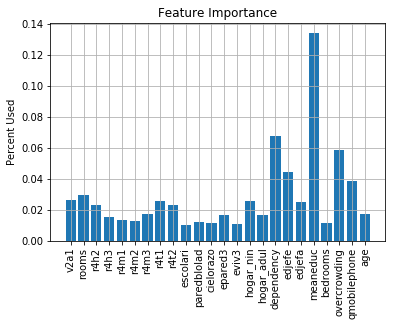

In [542]:
def key_extract(dic):
    y = pd.DataFrame.from_dict(dic, orient='index') #turns the dictionary into a data frame
    y = y.index # list of the names in the dataframe
    return y

def feature_extract(data_frame, feature_importances, sensitivity): # function to extract a list of features above a given sensitivty
    coef_dict = dict((zip(data_frame, feature_importances))) #creates a dictionary from the model's feature importance
    coef_list = {} # another dictionary
    for key in coef_dict: # runs through the zipped dictionary 
        x = coef_dict.get(key) # extracts value for the key
        if abs(x) > sensitivity:  # if the absolute value is bigger than the sensitivity
            coef_list[key] = x # adds a new entry to the other dictionary 
        else: # if the coefficient isn't big enough
            pass # move to the next key
    coef_list = key_extract(coef_list) # uses a previous function I wrote to make a list of the names of those coeff
    return coef_list # returns that list

best_feature = feature_extract(train_df, rfcb.feature_importances_, .01)

def best_feature_dict(list_, features_imp): #creates a dictionary from a list of tuples using another list of names
    y = {}
    for e in list_:
        y[e] = dict(features_imp).get(e)
    return y

def best_feature_plot(list_, features_imp, ticks=90):
    y = best_feature_dict(list_, features_imp)
    plt.bar(y.keys(),y.values())
    plt.title("Feature Importance")
    plt.xticks(rotation=ticks)
    plt.ylabel("Percent Used")
    plt.grid(True)
    
best_feature_plot(best_feature, feature_imp_rfc)

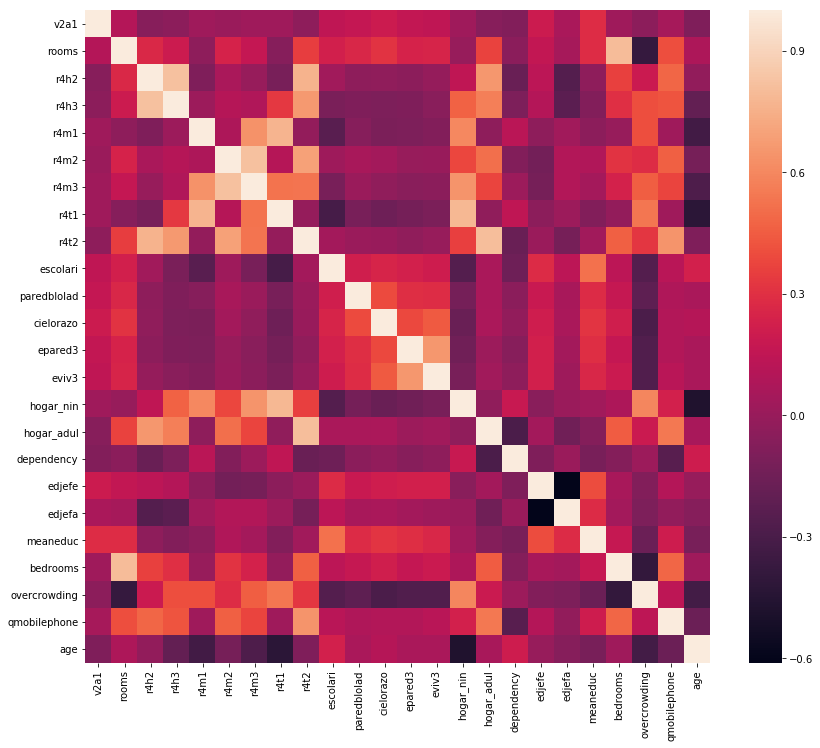

In [543]:
feature_corr = train_df[best_feature].corr()
f , ax = plt.subplots(figsize = (14,12)) #Makes it bigger
sns.heatmap(feature_corr)

The most important feature is mean education, by a large margin. Things dealing with overcrowding and education in general seem to be very important. I'll extract out a slightly smaller set and then see what I can do there. Also, some other investigations that goes lost because I forgot to set a random state lead to some other highly correlated variables that should be dropped, which will be discussed below before I get to my actual set of important features.

In [544]:
higher_sens = feature_extract(train_df, rfcb.feature_importances_, .02)

i_corr_extract(higher_sens, feature_corr, .3)

v2a1
{}

rooms
{'r4t2': 0.3492056517496821, 'cielorazo': 0.31051339130775474, 'hogar_adul': 0.36748095357973, 'bedrooms': 0.804070227268258, 'overcrowding': -0.3823637769112192, 'qmobilephone': 0.4042783187355396}

r4h2
{'r4h3': 0.8213670000361185, 'r4t2': 0.7633289995289202, 'hogar_adul': 0.6598794096337883, 'bedrooms': 0.36058199167738514, 'qmobilephone': 0.4788857316928849}

r4t1
{'r4h3': 0.3308274003901886, 'r4m1': 0.7674606306900226, 'r4m3': 0.5279029284437117, 'escolari': -0.31032877221994887, 'hogar_nin': 0.7821778682997236, 'overcrowding': 0.5367644082408002, 'age': -0.42381784828999886}

r4t2
{'rooms': 0.3492056517496821, 'r4h2': 0.7633289995289202, 'r4h3': 0.6630128659696134, 'r4m2': 0.6963681561381009, 'r4m3': 0.5306373704079804, 'hogar_nin': 0.35431848600921984, 'hogar_adul': 0.8055262737240599, 'bedrooms': 0.45908787083876507, 'overcrowding': 0.3266761801905336, 'qmobilephone': 0.6439713589815415}

hogar_nin
{'r4h3': 0.46727502149034505, 'r4m1': 0.6022810486095257, 'r4m2':

##### Things from the first go through that got lost:

Obviously number of tablets is correlated with having a tablet or not, so I'll drop the dummy. 'hacdor' (overcrowding by bedroom) is correlated with regular overcrowding. I don't know which to drop yet, so I'll look at the data. 'hacdor' has stronger importance, but 'overcrowding' is not a dummy, which I like more. Looking at 'hacdor', this is an indicator of poorer households, which is fairly nice because my model does less good at predicting those. So I'll leave both in for now. Also looking at that row, 'tamhog' and 'hhsize' are obviously perfectly correlated (and 'r4t3' as well) so I'll look at these in more detail. Looking at the correlation confirms this, so I'll just drop both 'tamhog' and 'hhsize'. The number of females (or males) in a household isn't correlated by age, but it is obviously correlated with the total of X. So I'll drop both of the totals.

##### Things from the second go through:

I'm already dropping 'r4h3' and 'r4m3'. Since I'm leaving in 'r4t3' I might remove 'r4t1' and 'r4t2' (since this is captured by the gender separated variables anyway). 'hacdor' isn't in this set but 'bedrooms' are. Since overcrowding is important and rooms and bedrooms are highly correlated, I'll drop out 'bedrooms' but leave in 'hacdor'. The number of children is highly correlated with many variables, some of which I am removing. Number of adults is correlated with cellphones. I might just remove both, since these are captured (for the most part) by many of the variables still remaining. It makes sense the two gendered education variables are negatively correlated, being variables that contradict each other. While mean education is highly correlated with "years in school" one is household level and the other individual so I think I'll keep both. I thought not having a ceiling might be a predictor of being poor, but apparently this isn't the case, so I guess I'll keep that variable. 

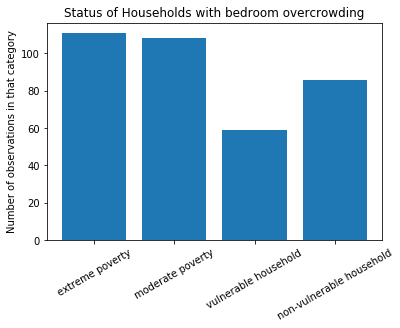

In [545]:
dicthac = dict(train_df.loc[train_df['hacdor'] == 1, 'Target'].value_counts())
statusplot(dicthac, "with bedroom overcrowding")

In [546]:
train_df[['tamhog','hhsize','r4t3', 'hogar_total']].corr() # are these correlated? they are 

,tamhog,hhsize,r4t3,hogar_total
tamhog,1.000000,1.000000,0.998107,1.000000
hhsize,1.000000,1.000000,0.998107,1.000000
r4t3,0.998107,0.998107,1.000000,0.998107
hogar_total,1.000000,1.000000,0.998107,1.000000


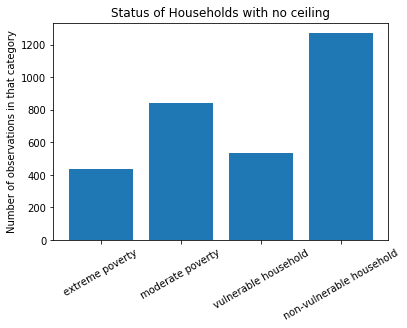

In [547]:
dictciel = dict(train_df.loc[train_df['cielorazo'] == 0, 'Target'].value_counts())
statusplot(dictciel, "with no ceiling")

In [548]:
droppables = ['v18q', 'tamhog', 'hhsize', 'r4m3', 'r4h3', 'r4t1', 'r4t2', 'bedrooms', 'hogar_nin', 'hogar_adul', 
             'hogar_total']

dropped_train = train_df.drop(columns = droppables) #Gets rid of the columns I feel I don't need

Now with this smaller variable list, I'll see how the random forest performs

In [611]:
# new model
scaler = StandardScaler()
no_target2 = dropped_train.drop(columns = 'Target')
scaler.fit(no_target2)
scaled_df2 = scaler.transform(no_target2)

In [550]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(scaled_df2, target_train, test_size=.2, random_state = 11)

In [551]:
rfcb.fit(X_train2, y_train2)
y_pred_train2 = rfcb.predict(X_train2)
print("Train F1: {}".format(f1_score(y_train2, y_pred_train2, average=None)))
print("Test Classification Report:")
y_pred_test2 = rfcb.predict(X_test2)
print(classification_report(y_test2, y_pred_test2))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train2, y_pred_train2),
                                                     accuracy_score(y_test2, y_pred_test2)))

Train F1: [0.92801252 0.9313387  0.8868101  0.96061293]
Test Classification Report:
              precision    recall  f1-score   support

           1       0.73      0.88      0.79       141
           2       0.81      0.82      0.81       314
           3       0.70      0.85      0.77       242
           4       0.95      0.89      0.92      1215

   micro avg       0.87      0.87      0.87      1912
   macro avg       0.80      0.86      0.82      1912
weighted avg       0.88      0.87      0.87      1912

Train Accuracy: 0.9425768476128188	Test accuracy: 0.8697698744769874


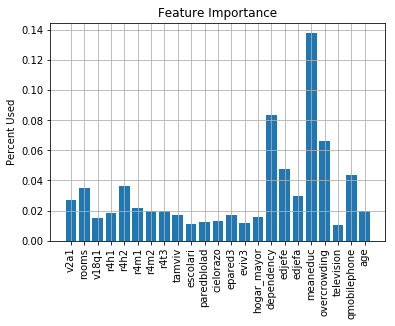

In [552]:
feature_imp_rfc2 = sorted(list(zip(dropped_train, rfcb.feature_importances_)), key=lambda x: x[1], reverse=True)
best_feature_drop = feature_extract(dropped_train, rfcb.feature_importances_, .01)
best_feature_plot(best_feature_drop, feature_imp_rfc2)

##### old classification report for scale

Train F1: [0.89581749 0.91353238 0.85043718 0.94546243]

Test Classification Report:
              precision    recall  f1-score   support

           1       0.64      0.87      0.73       141
           2       0.81      0.79      0.80       314
           3       0.62      0.81      0.70       242
           4       0.93      0.85      0.89      1215

   micro avg       0.83      0.83      0.83      1912
   
   macro avg       0.75      0.83      0.78      1912
   
weighted avg       0.85      0.83      0.84      1912

Train Accuracy: 0.9223021582733812	Test accuracy: 0.8331589958158996



Well, I improved slightly compared to the last random forest model and more importantly, I did better at improving my test accuracy than I did my train accuracy, so I guess I did something right. Unfortunately my train f1s are still much much better than my test, so overfitting is still an issue. The important features did mostly the same, so there is that as well. I'm going to try my overfitting nearest neighbors model as well with this slightly reduced data set but it will still probably be too overfitting (even if it performs better). 

In [559]:
knnb = KNeighborsClassifier(n_neighbors=5, p=1, weights='distance')
knnb.fit(X_train2, y_train2)
y_pred_train2 = knnb.predict(X_train2)
print("Train F1: {}".format(f1_score(y_train2, y_pred_train2, average=None)))
print("Test Classification Report:")
y_pred_test2 = knnb.predict(X_test2)
print(classification_report(y_test2, y_pred_test2))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train2, y_pred_train2),
                                                     accuracy_score(y_test2, y_pred_test2)))

Train F1: [1. 1. 1. 1.]
Test Classification Report:
              precision    recall  f1-score   support

           1       0.84      0.73      0.78       141
           2       0.88      0.73      0.80       314
           3       0.83      0.65      0.73       242
           4       0.88      0.97      0.92      1215

   micro avg       0.87      0.87      0.87      1912
   macro avg       0.86      0.77      0.81      1912
weighted avg       0.87      0.87      0.87      1912

Train Accuracy: 1.0	Test accuracy: 0.872907949790795


It does slightly worse than before (but better than the random forest if only looking at Test accuracy. When looking at the F1-scores, Random Forest does the same or better (especially for category 3), and has a slightly better macro average f1-score as well) while still overfitting the train data. I give up with this model, it makes no sense. I'll do a SVM too because those are my favorite. 

In [564]:
svmb = SVC(C=0.2, degree = 3, gamma = 1, kernel='poly')
svmb.fit(X_train2, y_train2)
y_pred_train2 = svmb.predict(X_train2)
print("Train F1: {}".format(f1_score(y_train2, y_pred_train2, average=None)))
print("Test Classification Report:")
y_pred_test2 = svmb.predict(X_test2)
print(classification_report(y_test2, y_pred_test2))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train2, y_pred_train2),
                                                     accuracy_score(y_test2, y_pred_test2)))

Train F1: [1. 1. 1. 1.]
Test Classification Report:
              precision    recall  f1-score   support

           1       0.77      0.77      0.77       141
           2       0.73      0.77      0.75       314
           3       0.75      0.64      0.69       242
           4       0.90      0.92      0.91      1215

   micro avg       0.85      0.85      0.85      1912
   macro avg       0.79      0.77      0.78      1912
weighted avg       0.85      0.85      0.85      1912

Train Accuracy: 1.0	Test accuracy: 0.8467573221757322


Technically did slightly better than the original SVM but still the inferior model overall. I'd try a gradient boost but I think my computer would kill me, it takes forever to do one. So overall, I've found that random forest works the best without overfitting (too much, it still is overfitting). This is evident not only in the average scores at the bottom but also that it predicts slightly better on each f1-score than KNN. It is interesting that random forest is better at recall, but the nearest neighbors model is more precise (except for group 4, the largest group, where it switches).  If I cared more, the next step would be more feature importances and analyses and then getting a better working gradient boost, but since we can't actually see how we do on the real test data, I don't really care. 